# Biosignal Analytics 2022
## EEG seizure detection

- Lauri Orava, 516761, laorav@utu.fi
- Emilia Kalliokoski, 2100413, emamka@utu.fi

### Library imports and data loading

In [98]:
# Library imports

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy
from IPython.display import display
import seaborn as sns

from scipy import signal
from sklearn import preprocessing

from scipy.signal import freqz, butter, lfilter

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import entropy

In [99]:
# Create lists of raw data
PATH_ns = os.path.join(os.getcwd(), 'Data', 'nonseizure')
PATH_s = os.path.join(os.getcwd(), 'Data', 'seizure')

raw_data_ns = []
raw_data_s = []

for file in glob.glob((PATH_ns+"/*.csv")):
    data = pd.read_csv(file)
    raw_data_ns.append(data)

for file in glob.glob((PATH_s+"/*.csv")):
    data = pd.read_csv(file)
    raw_data_s.append(data)

### Basic visualization of data

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

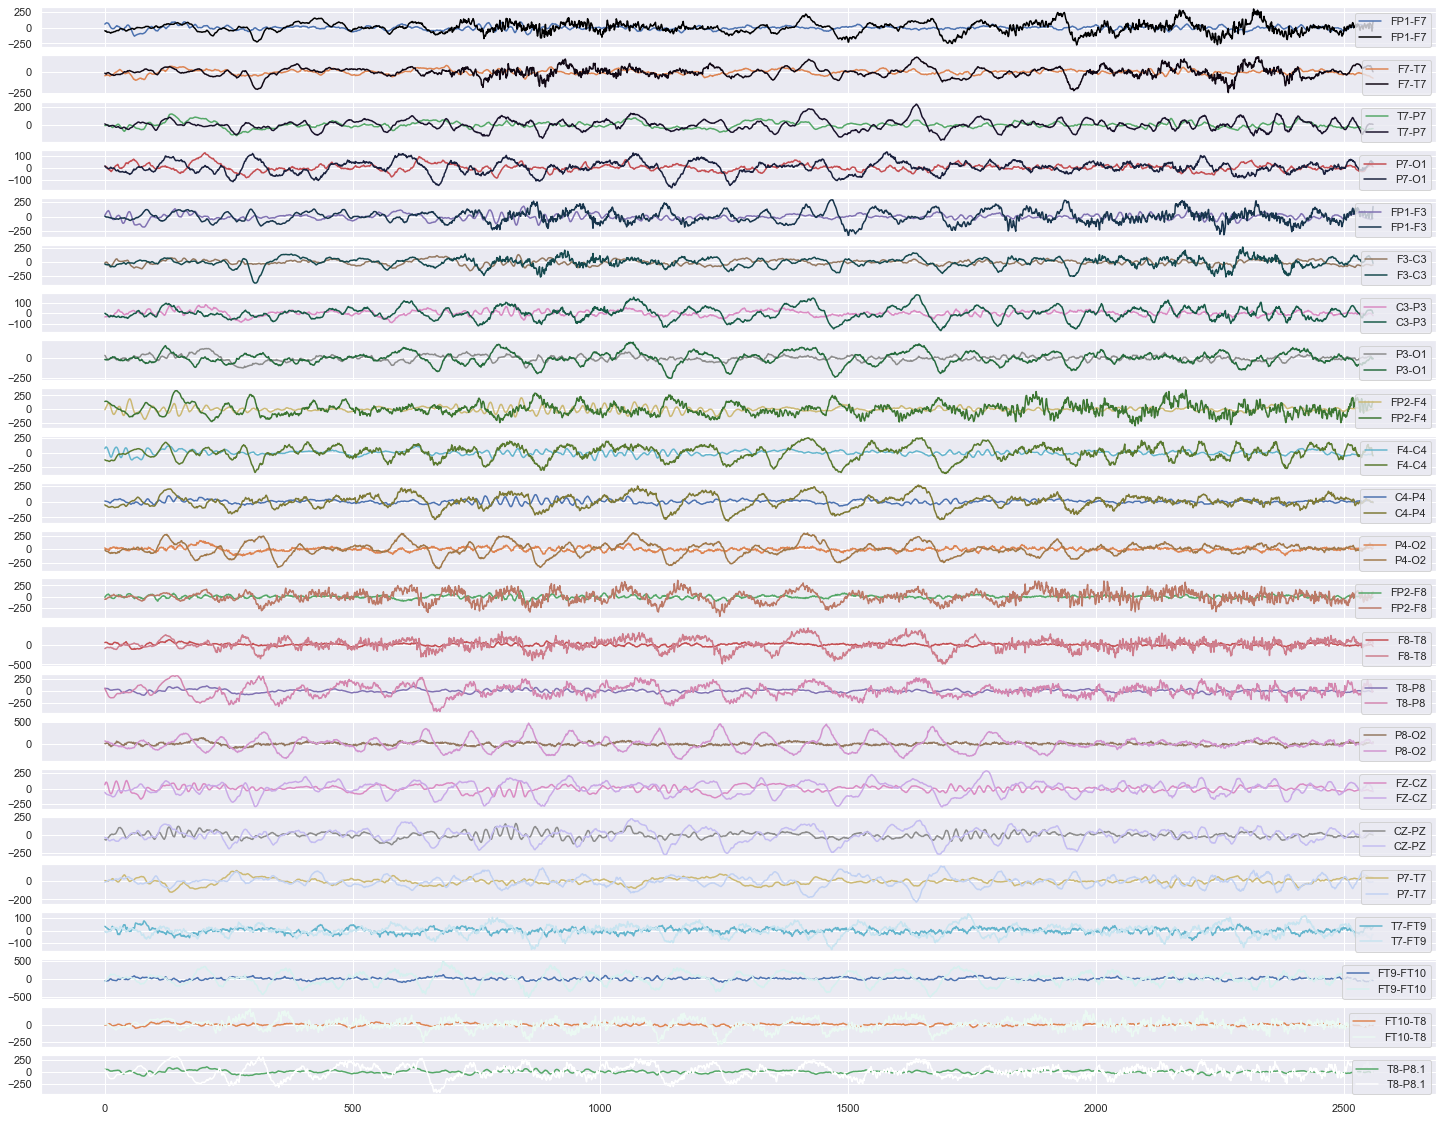

In [100]:
# Visualize data to better understand it
eeg_df_ns = raw_data_ns[0]
ax = eeg_df_ns.plot(subplots=True, figsize=(25, 20))

eeg_df_s = raw_data_s[0]
eeg_df_s.plot(ax=ax, subplots=True, figsize=(25, 20), colormap='cubehelix')

### Filtering

In [101]:
# Functions for filtering all of the data channels
def butter_bandpass_filter(lowcut, highcut, freq, order, data):
  sampling_rate = 0.5*freq
  b,a = butter(order, [lowcut/sampling_rate, highcut/sampling_rate], btype = 'band')
  y = lfilter(b,a,data)
  return y

def bb_filter_eeg_samples(data, lowcut, highcut, freq, order):
  filtered_data = []
  for i in range (0, len(data)):
    temp_df = data[i]
    filtered = dict()
    for j in temp_df.columns:
      channel = temp_df[j].values
      filtered[j] = butter_bandpass_filter(lowcut, highcut, freq, order, channel)
    filtered_data.append(pd.DataFrame.from_dict(filtered))
  return filtered_data

In [102]:
# Filtering the data with the Butterworth bandpass filter
# Low-pass and high-pass frequencies chosen based on typical practices
s_filtered = bb_filter_eeg_samples(raw_data_s, 0.1, 50, 256, 4)
ns_filtered = bb_filter_eeg_samples(raw_data_ns, 0.1, 50, 256, 4)

### Feature extraction

In [108]:
# Extract summary statistics (mean, standard deviation, median) and entropy from EEG data
def summary_statistics_eeg(data):
    means = pd.DataFrame(columns=list(data[0].columns + ' mean'))
    stds = pd.DataFrame(columns=list(data[0].columns + ' std'))
    medians = pd.DataFrame(columns=list(data[0].columns + ' md'))
    entropys = pd.DataFrame(columns=list(data[0].columns + ' entropy'))
    for i in range (0, len(data)):
        temp_df = data[i]
        mean = []
        std = []
        median = []
        entropylist = []
        for j in range(0, len(temp_df.columns)):
            mean.append(temp_df.iloc[:, j].mean())
            std.append(temp_df.iloc[:, j].std())
            median.append(temp_df.iloc[:, j].median())
            entropylist.append(entropy(temp_df.iloc[:, j].value_counts()))
        means.loc[i] = mean
        stds.loc[i] = std
        medians.loc[i] = median
        entropys.loc[i] = entropylist
    summary_statistics = pd.concat([means, stds, medians, entropys], axis=1)
    return summary_statistics

In [109]:
# Extract summary statistics using our function from all of the (un)filtered (non)seizure data channels
raw_ns_stats = summary_statistics_eeg(raw_data_ns)
raw_s_stats = summary_statistics_eeg(raw_data_s)
filtered_ns_stats = summary_statistics_eeg(ns_filtered)
filtered_s_stats = summary_statistics_eeg(s_filtered)

In [110]:
# Column names for PSD bin dataframe
bin_df_columns = []
for i in range(0, len(raw_data_s[0].columns)):
    for j in range(1,6):
        bin_df_columns.append(raw_data_s[0].columns[i] + " bin " + str(j))

# Column names for dominant frequency dataframe
dom_freq_columns = []
for i in range(0, len(raw_data_s[0].columns)):
    dom_freq_columns.append(raw_data_s[0].columns[i] + " dom freq")

In [111]:
# PSD bins for unfiltered non-seizure and seizure data
# Data is divided into five bins, amount of bins subject to change

freqs_arr = np.arange(0,51,10)

unfiltered_s_bin_array = []
unfiltered_s_dom_freqs = []
for i in range(0, len(raw_data_s)):
    norm_sample = preprocessing.scale(raw_data_s[i])
    bin_array = []
    freq_array = []
    for j in range(0, norm_sample.shape[1]):
        frequencies, PSD = signal.welch(norm_sample[:,j], fs=256, nperseg=10*256)
        dom_freq = frequencies[PSD.tolist().index(max(PSD))]
        freq_array.append(dom_freq)
        PSD_binned_sum = []
        for k in range(freqs_arr.shape[0]-1):
            PSD_binned_sum.append(np.sum(PSD[np.where((frequencies >= freqs_arr[k]) & (frequencies < freqs_arr[k+1]))]))
        for m in PSD_binned_sum:
            bin_array.append(m)
    unfiltered_s_bin_array.append(bin_array)
    unfiltered_s_dom_freqs.append(freq_array)
unfiltered_s_bin_df = pd.DataFrame(unfiltered_s_bin_array, columns=bin_df_columns)
unfiltered_s_dom_freqs_df = pd.DataFrame(unfiltered_s_dom_freqs, columns=dom_freq_columns)

unfiltered_ns_bin_array = []
unfiltered_ns_dom_freqs = []
for i in range(0, len(raw_data_ns)):
    norm_sample = preprocessing.scale(raw_data_ns[i])
    bin_array = []
    freq_array = []
    for j in range(0, norm_sample.shape[1]):
        frequencies, PSD = signal.welch(norm_sample[:,j], fs=256, nperseg=10*256)
        dom_freq = frequencies[PSD.tolist().index(max(PSD))]
        freq_array.append(dom_freq)
        PSD_binned_sum = []
        for k in range(freqs_arr.shape[0]-1):
            PSD_binned_sum.append(np.sum(PSD[np.where((frequencies >= freqs_arr[k]) & (frequencies < freqs_arr[k+1]))]))
        for m in PSD_binned_sum:
            bin_array.append(m)
    unfiltered_ns_bin_array.append(bin_array)
    unfiltered_ns_dom_freqs.append(freq_array)
unfiltered_ns_bin_df = pd.DataFrame(unfiltered_ns_bin_array, columns=bin_df_columns)
unfiltered_ns_dom_freqs_df = pd.DataFrame(unfiltered_ns_dom_freqs, columns=dom_freq_columns)

# PSD bins for filtered non-seizure and seizure data

filtered_s_bin_array = []
filtered_s_dom_freqs = []
for i in range(0, len(s_filtered)):
    norm_sample = preprocessing.scale(s_filtered[i])
    bin_array = []
    freq_array = []
    for j in range(0, norm_sample.shape[1]):
        frequencies, PSD = signal.welch(norm_sample[:,j], fs=256, nperseg=10*256)
        dom_freq = frequencies[PSD.tolist().index(max(PSD))]
        freq_array.append(dom_freq)
        PSD_binned_sum = []
        for k in range(freqs_arr.shape[0]-1):
            PSD_binned_sum.append(np.sum(PSD[np.where((frequencies >= freqs_arr[k]) & (frequencies < freqs_arr[k+1]))]))
        for m in PSD_binned_sum:
            bin_array.append(m)
    filtered_s_bin_array.append(bin_array)
    filtered_s_dom_freqs.append(freq_array)
filtered_s_bin_df = pd.DataFrame(filtered_s_bin_array, columns=bin_df_columns)
filtered_s_dom_freqs_df = pd.DataFrame(filtered_s_dom_freqs, columns=dom_freq_columns)

filtered_ns_bin_array = []
filtered_ns_dom_freqs = []
for i in range(0, len(ns_filtered)):
    norm_sample = preprocessing.scale(ns_filtered[i])
    bin_array = []
    freq_array = []
    for j in range(0, norm_sample.shape[1]):
        frequencies, PSD = signal.welch(norm_sample[:,j], fs=256, nperseg=10*256)
        dom_freq = frequencies[PSD.tolist().index(max(PSD))]
        freq_array.append(dom_freq)
        PSD_binned_sum = []
        for k in range(freqs_arr.shape[0]-1):
            PSD_binned_sum.append(np.sum(PSD[np.where((frequencies >= freqs_arr[k]) & (frequencies < freqs_arr[k+1]))]))
        for m in PSD_binned_sum:
            bin_array.append(m)
    filtered_ns_bin_array.append(bin_array)
    filtered_ns_dom_freqs.append(freq_array)
filtered_ns_bin_df = pd.DataFrame(filtered_ns_bin_array, columns=bin_df_columns)
filtered_ns_dom_freqs_df = pd.DataFrame(filtered_ns_dom_freqs, columns=dom_freq_columns)

In [112]:
# Concatenate all extracted features into one dataframe and add labels (non-seizure = 0, seizure = 1)
unfiltered_ns_features = pd.concat([raw_ns_stats, unfiltered_ns_bin_df, unfiltered_ns_dom_freqs_df], axis=1)
unfiltered_ns_features['label'] = 0

unfiltered_s_features = pd.concat([raw_s_stats, unfiltered_s_bin_df, unfiltered_s_dom_freqs_df], axis=1)
unfiltered_s_features['label'] = 1

filtered_ns_features = pd.concat([filtered_ns_stats, filtered_ns_bin_df, filtered_ns_dom_freqs_df], axis=1)
filtered_ns_features['label'] = 0

filtered_s_features = pd.concat([filtered_s_stats, filtered_s_bin_df, filtered_s_dom_freqs_df], axis=1)
filtered_s_features['label'] = 1

unfiltered_features = pd.concat([unfiltered_ns_features, unfiltered_s_features], axis=0)
filtered_features = pd.concat([filtered_ns_features, filtered_s_features], axis=0)

In [113]:
# Display first five rows from both complete feature dataframes to check results

display(unfiltered_features.head())
display(filtered_features.head())

,FP1-F7 mean,F7-T7 mean,T7-P7 mean,P7-O1 mean,FP1-F3 mean,F3-C3 mean,C3-P3 mean,P3-O1 mean,FP2-F4 mean,F4-C4 mean,...,T8-P8 dom freq,P8-O2 dom freq,FZ-CZ dom freq,CZ-PZ dom freq,P7-T7 dom freq,T7-FT9 dom freq,FT9-FT10 dom freq,FT10-T8 dom freq,T8-P8.1 dom freq,label
0,-0.402778,0.211538,-0.701465,0.846154,-0.496490,-0.704060,0.329060,0.652167,-1.004884,-0.323718,...,3.3,0.7,1.1,0.5,0.9,1.2,1.6,3.3,3.3,0
1,0.508394,2.308455,3.862790,1.992521,-0.456807,2.598291,2.872863,3.744505,-0.287393,-1.392094,...,1.2,1.2,1.0,1.2,1.1,1.9,1.3,1.0,1.2,0
2,-0.574786,-1.023352,0.308913,1.052198,0.401404,-0.833639,0.191850,0.074023,0.599512,0.193529,...,1.2,1.1,0.6,1.1,1.0,1.6,16.0,1.1,1.2,0
3,-0.916972,0.786325,-0.688187,-1.084707,-0.556471,0.299756,-1.157967,-0.459707,-0.045177,-1.033730,...,1.0,1.0,0.9,1.0,1.5,16.0,16.0,1.1,1.0,0
4,0.145604,-0.903694,0.749389,-0.057387,0.272894,-1.247711,0.708486,0.190934,-0.590965,0.114469,...,0.9,1.4,1.3,0.7,0.9,2.9,1.7,1.5,0.9,0


,FP1-F7 mean,F7-T7 mean,T7-P7 mean,P7-O1 mean,FP1-F3 mean,F3-C3 mean,C3-P3 mean,P3-O1 mean,FP2-F4 mean,F4-C4 mean,...,T8-P8 dom freq,P8-O2 dom freq,FZ-CZ dom freq,CZ-PZ dom freq,P7-T7 dom freq,T7-FT9 dom freq,FT9-FT10 dom freq,FT10-T8 dom freq,T8-P8.1 dom freq,label
0,-0.131554,-0.501791,-0.726000,-0.173997,-0.255233,-1.096756,-0.200321,-0.013930,-0.324634,-0.453929,...,3.3,0.7,1.1,0.5,0.9,1.2,1.6,3.3,3.3,0
1,0.996941,0.755209,0.756227,0.180929,0.855353,0.888275,0.284219,0.610353,-0.079233,1.114721,...,1.2,1.1,1.0,1.2,1.1,1.9,1.3,1.0,1.2,0
2,-0.135983,-0.600559,0.025540,0.801158,0.119470,-0.729644,0.438663,0.246708,0.191823,0.647983,...,1.2,1.1,0.6,1.1,1.0,1.6,16.0,1.1,1.2,0
3,-0.356652,0.154665,-0.409141,-0.067626,-0.228158,0.014711,-0.208863,-0.254026,-0.134526,-0.458166,...,1.0,1.0,0.9,1.0,1.5,16.0,16.0,1.1,1.0,0
4,0.474739,-0.912563,-0.714783,-0.714853,1.117148,-1.714395,-0.422421,-0.880638,0.277384,-0.552908,...,0.9,1.4,1.3,0.7,0.9,2.9,1.7,1.5,0.9,0


In [114]:
# Dividing the complete dataframes into X (features) and y (labels)

unfiltered_X = unfiltered_features.iloc[:, :len(unfiltered_features.columns)-1]
unfiltered_y = unfiltered_features.iloc[:, len(unfiltered_features.columns)-1:]

filtered_X = filtered_features.iloc[:, :len(unfiltered_features.columns)-1]
filtered_y = filtered_features.iloc[:, len(unfiltered_features.columns)-1:]

In [115]:
# Dividing the data into training (70 %) and testing (30 %) sets. We use a seed number to get same resuls each time the code is run for better comparison

unfiltered_X_train, unfiltered_X_test, unfiltered_y_train, unfiltered_y_test = train_test_split(unfiltered_X, unfiltered_y, test_size=0.3, train_size=0.7, random_state=123, shuffle=True)

filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test = train_test_split(filtered_X, filtered_y, test_size=0.3, train_size=0.7, random_state=123, shuffle=True)

In [116]:
# Calculating meand and stds of the unfiltered and filtered training sets

unfiltered_X_train_mean = unfiltered_X_train.mean()
unfiltered_X_train_std = unfiltered_X_train.std()

filtered_X_train_mean = filtered_X_train.mean()
filtered_X_train_std = filtered_X_train.std()

In [117]:
# Stanzardizing the training and testing sets using means and stds of the training sets
# Regular Z-score standardization is used ((X - mean) / std)

unfiltered_X_train_z = (unfiltered_X_train - unfiltered_X_train_mean) / unfiltered_X_train_std
unfiltered_X_test_z = (unfiltered_X_test - unfiltered_X_train_mean) / unfiltered_X_train_std

filtered_X_train_z = (filtered_X_train - filtered_X_train_mean) / filtered_X_train_std
filtered_X_test_z = (filtered_X_test - filtered_X_train_mean) / filtered_X_train_std

In [118]:
# Converting dataframes to numpys for easier use

unfiltered_X_train_z_np = unfiltered_X_train_z.to_numpy()
unfiltered_y_train_np = unfiltered_y_train.to_numpy()
unfiltered_X_test_z_np = unfiltered_X_test_z.to_numpy()
unfiltered_y_test_np = unfiltered_y_test.to_numpy()

filtered_X_train_z_np = filtered_X_train_z.to_numpy()
filtered_y_train_np = filtered_y_train.to_numpy()
filtered_X_test_z_np = filtered_X_test_z.to_numpy()
filtered_y_test_np = filtered_y_test.to_numpy()

In [119]:
### Logistic regression for binary classification

## Unfiltered data

# Logistic regression model
unfiltered_logit = LogisticRegression().fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())
unfiltered_logit_preds = unfiltered_logit.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_logit_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_logit_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_logit_preds))

## Filtered data

# Logistic regression model
filtered_logit = LogisticRegression().fit(filtered_X_train_z_np, filtered_y_train_np.ravel())
filtered_logit_preds = filtered_logit.predict(filtered_X_test_z_np)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_logit_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_logit_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_logit_preds))

For unfiltered data: 

Confusion matrix:
[[120   2]
 [  4  96]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       122
           1       0.98      0.96      0.97       100

    accuracy                           0.97       222
   macro avg       0.97      0.97      0.97       222
weighted avg       0.97      0.97      0.97       222

Accuracy:  0.972972972972973

For filtered data: 

Confusion matrix:
[[113   9]
 [  9  91]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       122
           1       0.91      0.91      0.91       100

    accuracy                           0.92       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222

Accuracy:  0.918918918918919


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
### Random forest

## Unfiltered data

# Random forest model
unfiltered_forest = RandomForestClassifier(n_estimators=100).fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())

unfiltered_forest_preds = unfiltered_forest.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_forest_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_forest_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_forest_preds))

## Filtered data

# Random forest model
filtered_forest = RandomForestClassifier(n_estimators=100).fit(filtered_X_train_z_np, filtered_y_train_np.ravel())

filtered_forest_preds = filtered_forest.predict(filtered_X_test_z_np)

print("For filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_forest_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_forest_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_forest_preds))

For unfiltered data: 

Confusion matrix:
[[119   3]
 [  5  95]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       122
           1       0.97      0.95      0.96       100

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

Accuracy:  0.963963963963964
For filtered data: 

Confusion matrix:
[[120   2]
 [  7  93]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       122
           1       0.98      0.93      0.95       100

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

Accuracy:  0.9594594594594594


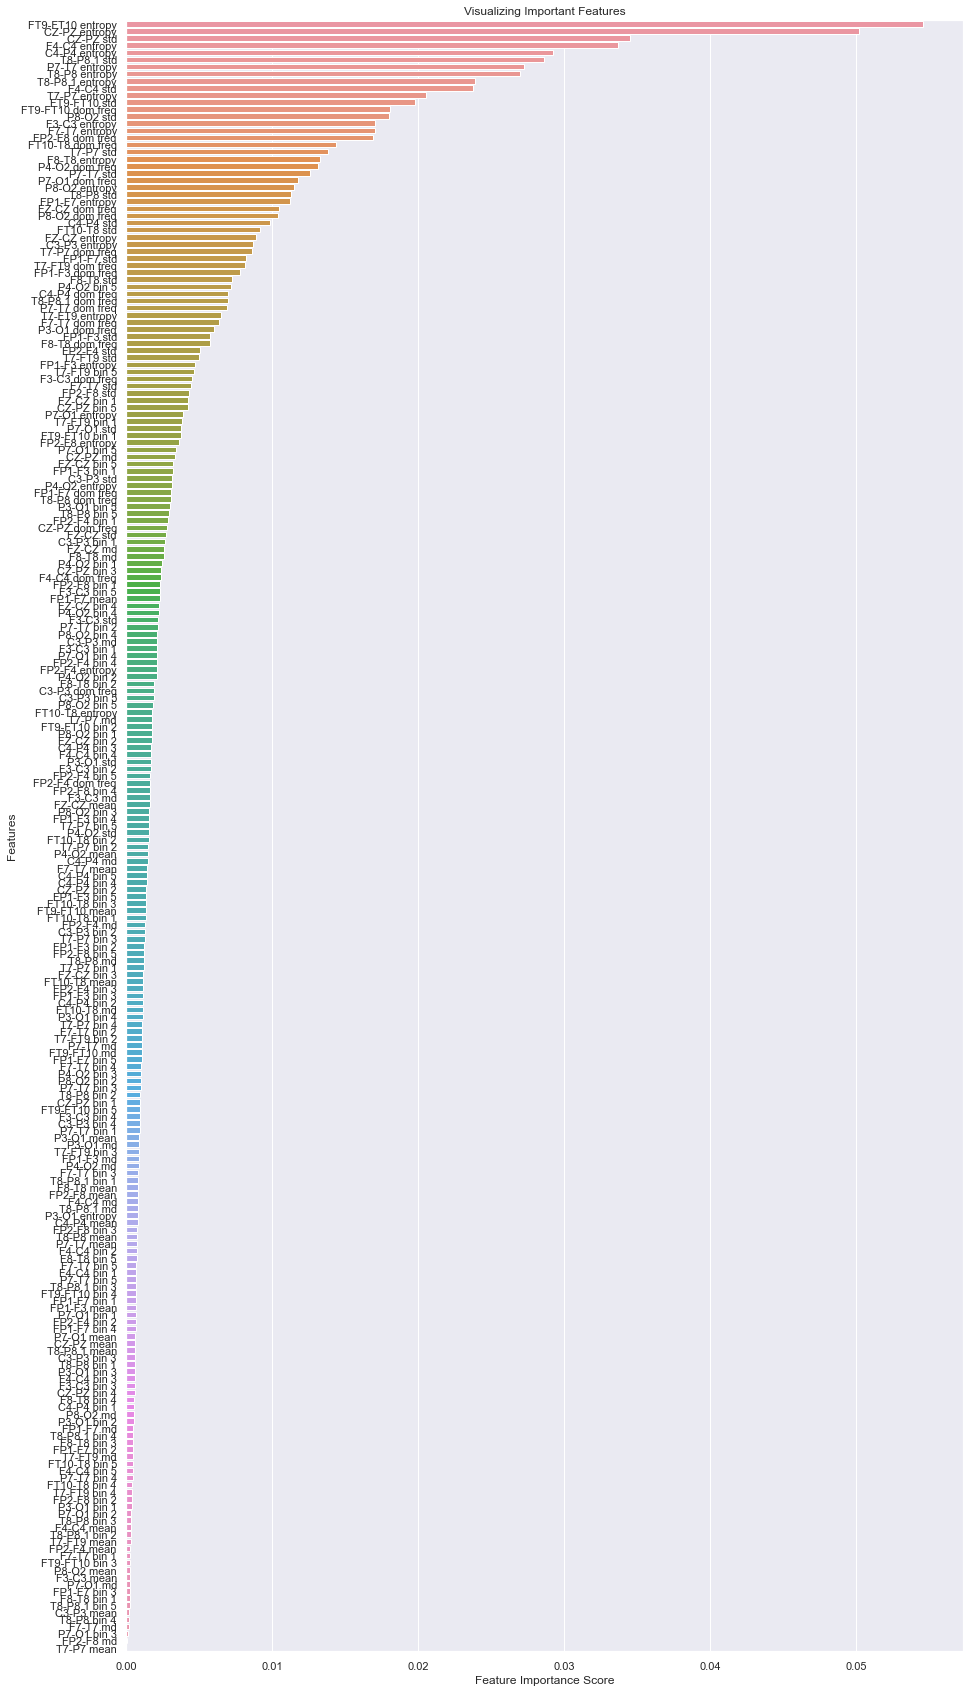

In [126]:
feature_imp = pd.Series(unfiltered_forest.feature_importances_,index=unfiltered_X_train_z.columns).sort_values(ascending=False)

%matplotlib inline
# Creating a bar plot
sns.set(rc = {'figure.figsize':(15,30)})
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [122]:
### Support vector machine

## Unfiltered data

# SVM model

unfiltered_svm = svm.SVC(kernel="rbf").fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())
unfiltered_svm_preds = unfiltered_svm.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_svm_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_svm_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_svm_preds))

## Filtered data

# SVM model

filtered_svm = svm.SVC().fit(filtered_X_train_z_np, filtered_y_train_np.ravel())
filtered_svm_preds = filtered_svm.predict(filtered_X_test_z_np)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_svm_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_svm_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_svm_preds))

For unfiltered data: 

Confusion matrix:
[[118   4]
 [  5  95]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       122
           1       0.96      0.95      0.95       100

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

Accuracy:  0.9594594594594594

For filtered data: 

Confusion matrix:
[[120   2]
 [  9  91]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       122
           1       0.98      0.91      0.94       100

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222

Accuracy:  0.9504504504504504


In [123]:
# PCA with 10 components to reduce the amount of features

unfiltered_train_pca = PCA(n_components=10)
unfiltered_X_train_pca = unfiltered_train_pca.fit_transform(unfiltered_X_train_z_np)

filtered_train_pca = PCA(n_components=10)
filtered_X_train_pca = filtered_train_pca.fit_transform(filtered_X_train_z_np)

unfiltered_test_pca = PCA(n_components=10)
unfiltered_X_test_pca = unfiltered_test_pca.fit_transform(unfiltered_X_test_z_np)

filtered_test_pca = PCA(n_components=10)
filtered_X_test_pca = filtered_test_pca.fit_transform(filtered_X_test_z_np)

In [124]:
### Logistic regression for PCA data

## Unfiltered data

# Logistic regression model
unfiltered_logit_pca = LogisticRegression().fit(unfiltered_X_train_pca, unfiltered_y_train_np.ravel())
unfiltered_logit_preds_pca = unfiltered_logit_pca.predict(unfiltered_X_test_pca)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_logit_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_logit_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_logit_preds_pca))

## Filtered data

# Logistic regression model
filtered_logit_pca = LogisticRegression().fit(filtered_X_train_pca, filtered_y_train_np.ravel())
filtered_logit_preds_pca = filtered_logit_pca.predict(filtered_X_test_pca)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_logit_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_logit_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_logit_preds_pca))

For unfiltered data: 

Confusion matrix:
[[46 76]
 [90 10]]
              precision    recall  f1-score   support

           0       0.34      0.38      0.36       122
           1       0.12      0.10      0.11       100

    accuracy                           0.25       222
   macro avg       0.23      0.24      0.23       222
weighted avg       0.24      0.25      0.24       222

Accuracy:  0.25225225225225223

For filtered data: 

Confusion matrix:
[[96 26]
 [38 62]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       122
           1       0.70      0.62      0.66       100

    accuracy                           0.71       222
   macro avg       0.71      0.70      0.70       222
weighted avg       0.71      0.71      0.71       222

Accuracy:  0.7117117117117117


In [125]:
### Support vector machine for PCA data

## Unfiltered data

# SVM model

unfiltered_svm_pca = svm.SVC().fit(unfiltered_X_train_pca, unfiltered_y_train_np.ravel())
unfiltered_svm_preds_pca = unfiltered_svm_pca.predict(unfiltered_X_test_pca)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_svm_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_svm_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_svm_preds_pca))

## Filtered data

# SVM model

filtered_svm_pca = svm.SVC().fit(filtered_X_train_pca, filtered_y_train_np.ravel())
filtered_svm_preds_pca = filtered_svm_pca.predict(filtered_X_test_pca)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_svm_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_svm_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_svm_preds_pca))

For unfiltered data: 

Confusion matrix:
[[37 85]
 [65 35]]
              precision    recall  f1-score   support

           0       0.36      0.30      0.33       122
           1       0.29      0.35      0.32       100

    accuracy                           0.32       222
   macro avg       0.33      0.33      0.32       222
weighted avg       0.33      0.32      0.32       222

Accuracy:  0.32432432432432434

For filtered data: 

Confusion matrix:
[[100  22]
 [ 17  83]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       122
           1       0.79      0.83      0.81       100

    accuracy                           0.82       222
   macro avg       0.82      0.82      0.82       222
weighted avg       0.83      0.82      0.82       222

Accuracy:  0.8243243243243243
